# Decomposing orthogonal matrices as product of Householder reflections

## Imports

In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.linalg as lin
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

## Computing the product

In [14]:
def householder_constructor(vs):
    
    num_vs, v_dim = vs.shape
    
    I = torch.eye(v_dim, v_dim).double()
    
    P = I
    
    for i in range(num_vs):
        
        v = vs[i].view(-1, 1)
        v = v / lin.vector_norm(v)

        P = (I - 2 * v @ v.T) @ P
        
    return P

Since Householder matrices are orthogonal, chaining two identical ones lead to an identity matrix.

In [15]:
v = torch.randn(1, 100).double()  # make sure to use doubles lol
vs = torch.zeros(2, 100).double()
vs[0] = v
vs[1] = v
torch.allclose(householder_constructor(vs), torch.eye(100).double())

True

## Computing the minimal "Householder rank"

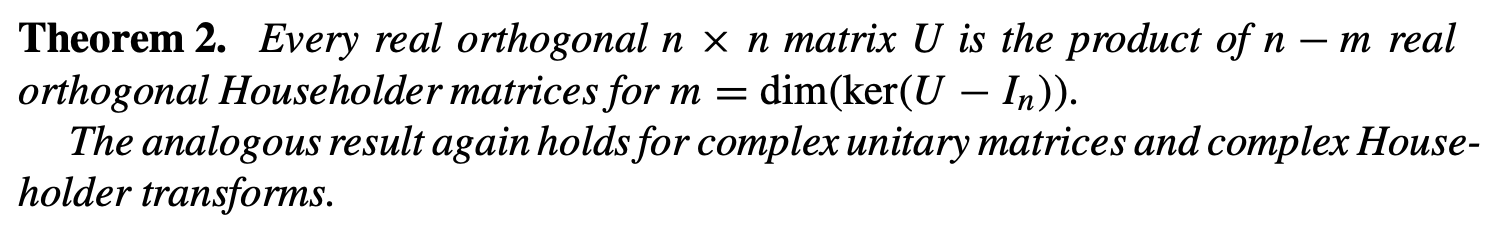

In [16]:
def min_householder_rank(omat, tol=1e-8):
    
    # Based on Theorem 2 of
    # 
    # Constructive ways for generating (generalized) real orthogonal matrices as products of
    # (generalized) symmetries 
    # 
    # Frank Uhlig∗
    # 
    # Theorem 2. Every real orthogonal n × n matrix U is the product of n − m real
    # orthogonal Householder matrices for m = dim(ker(U − In)).
    #
    # omat stands for "orthogonal matrix"
    # Assume omat is of type Double
    
    assert omat.type() == "torch.DoubleTensor"  # important for precision (atol was set for this type)
    assert len(omat.shape) == 2  # 2D matrix
    assert omat.shape[0] == omat.shape[1]  # square matrix
    
    n = omat.shape[0]
    I_n = torch.eye(n).double()
    
    assert torch.allclose(omat.T @ omat, I_n)  # orthogonality
    
    # Check eigenvalues to determine the dimensionality of the null space
    # https://stackoverflow.com/questions/5889142/python-numpy-scipy-finding-the-null-space-of-a-matrix
    
    eigvals = lin.eigvals(omat - I_n)
    dim_null = torch.sum((eigvals.real.abs() < tol) & (eigvals.imag.abs() < tol))
    
    return int(n - dim_null)

Empirically, random orthogonal matrices are equally likely to have a minimal householder rank of $n$ or $n-1$. This is quite surprising.

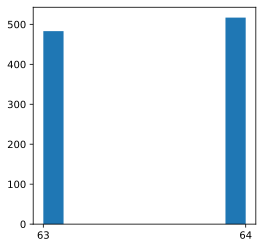

In [17]:
n = 64
min_householder_ranks = []

for i in range(1000):

    omat = ortho_group.rvs(n)  # generate random orthogonal matrix
    omat = torch.from_numpy(omat).double()

    min_householder_ranks.append(min_householder_rank(omat))
    
plt.figure(figsize=(4, 4))
plt.hist(min_householder_ranks)
plt.xticks([n-1, n])
plt.show()

We see that the composition of $k$ random Householder reflections has a minimal Householder rank of $k$.

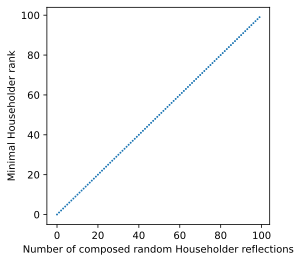

In [18]:
min_householder_ranks = []
for i in range(100):
    min_householder_ranks.append(
        min_householder_rank(householder_constructor(torch.randn(i, 100).double()))
    )

plt.figure(figsize=(4, 4))
plt.scatter(list(range(100)), min_householder_ranks, s=1)
plt.xlabel("Number of composed random Householder reflections")
plt.ylabel("Minimal Householder rank")
plt.show()

## Reconstructing a random orthogonal matrix

But odd number of householder transformations cannot model the identity transform. This should be easy to prove. 

Ref: https://scicomp.stackexchange.com/questions/34240/why-householder-transformation-can-not-be-chosen-to-be-an-identity-matrix#:~:text=By%20definition%2C%20the%20Householder%20transformation,cannot%20be%20the%20identity%20matrix.

### Minimal householder rank of 63

In [390]:
n = 64

while True:
    target = ortho_group.rvs(D)
    target = torch.from_numpy(target).double()
    if min_householder_rank(target) == 63:
        break

Hs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68]

mean_abs_diffs = []

for H in Hs:

    print(f"H = {H}")

    vs = nn.Parameter((torch.randn(H, n)).double())
    opt = optim.Adam([vs], lr=1e-1)

    for j in range(1, 501):

        Q = householder_constructor(vs)
        loss = torch.mean((Q - target) ** 2)
        opt.zero_grad()
        loss.backward()

        if j % 100 == 0:
            print(f"Loss: {float(loss)} | Grad norm: {torch.linalg.norm(vs.grad)}")

        opt.step()

    Q = householder_constructor(vs)
    mean_abs_diff = torch.mean(torch.abs(Q - target))  # a more intuitive metric
    mean_abs_diffs.append(float(mean_abs_diff))

H = 1
Loss: 0.030304459746949914 | Grad norm: 3.955870270674141e-06
Loss: 0.030293853140202893 | Grad norm: 1.1991415654137567e-06
Loss: 0.03029155150950717 | Grad norm: 7.223031960033989e-07
Loss: 0.030290104148184317 | Grad norm: 5.825900244315964e-07
Loss: 0.03028903247307953 | Grad norm: 4.596200663160908e-07
H = 5
Loss: 0.0265487768350374 | Grad norm: 9.914723873948811e-06
Loss: 0.026424705358739062 | Grad norm: 4.06743118379789e-06
Loss: 0.026407376208346687 | Grad norm: 1.3246763062606952e-06
Loss: 0.02640490902294481 | Grad norm: 5.036679801352013e-07
Loss: 0.026404424244631283 | Grad norm: 2.317971954587301e-07
H = 10
Loss: 0.02191210015860615 | Grad norm: 1.369699906777584e-05
Loss: 0.021790611062211765 | Grad norm: 4.6487913545579474e-06
Loss: 0.02176384414353154 | Grad norm: 2.27296888454965e-06
Loss: 0.021752726510071305 | Grad norm: 1.519948280713091e-06
Loss: 0.02174713390517559 | Grad norm: 9.398633431414102e-07
H = 15
Loss: 0.01742755095872501 | Grad norm: 2.2584499067

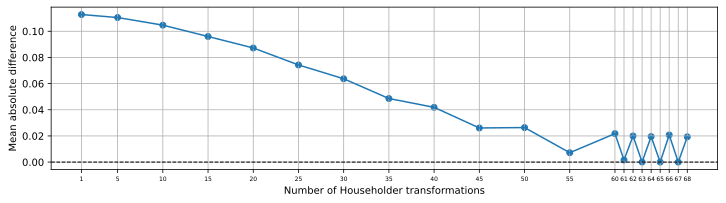

In [393]:
plt.figure(figsize=(12, 3))
plt.plot(Hs, mean_abs_diffs)
plt.scatter(Hs, mean_abs_diffs)
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid()
plt.ylabel("Mean absolute difference")
plt.xlabel("Number of Householder transformations")
plt.xticks(Hs, fontsize=6)
plt.savefig("num_householders_vs_recon_perf_63.png", dpi=300)

### Minimal householder rank of 64

In [394]:
n = 64

while True:
    target = ortho_group.rvs(D)  #
    target = torch.from_numpy(target).double()
    if min_householder_rank(target) == 64:
        break

Hs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68]

mean_abs_diffs = []

for H in Hs:

    print(f"H = {H}")

    vs = nn.Parameter((torch.randn(H, n)).double())
    opt = optim.Adam([vs], lr=1e-1)

    for j in range(1, 501):

        Q = householder_constructor(vs)
        loss = torch.mean((Q - target) ** 2)
        opt.zero_grad()
        loss.backward()

        if j % 100 == 0:
            print(f"Loss: {float(loss)} | Grad norm: {torch.linalg.norm(vs.grad)}")

        opt.step()

    Q = householder_constructor(vs)
    mean_abs_diff = torch.mean(torch.abs(Q - target))  # a more intuitive metric
    mean_abs_diffs.append(float(mean_abs_diff))

H = 1
Loss: 0.030113392593146687 | Grad norm: 4.482695566201396e-06
Loss: 0.030099818268214437 | Grad norm: 1.9301822114945306e-06
Loss: 0.030095811630637247 | Grad norm: 9.142438452416249e-07
Loss: 0.03009421331723735 | Grad norm: 5.24167553976714e-07
Loss: 0.030093592085665585 | Grad norm: 3.108617073888851e-07
H = 5
Loss: 0.02629939936062342 | Grad norm: 8.15438855603031e-06
Loss: 0.026256038050975684 | Grad norm: 3.703045446146984e-06
Loss: 0.02622680562566644 | Grad norm: 2.7422862313830598e-06
Loss: 0.026217724960283233 | Grad norm: 8.576603845046639e-07
Loss: 0.026216903206058222 | Grad norm: 1.9677518554081415e-07
H = 10
Loss: 0.021683180487491037 | Grad norm: 1.462454120835537e-05
Loss: 0.02154386591807249 | Grad norm: 6.036840420569029e-06
Loss: 0.021477583524446425 | Grad norm: 3.413831841261456e-06
Loss: 0.0214665897597212 | Grad norm: 4.0009942570266547e-07
Loss: 0.021466451359478105 | Grad norm: 2.747453842728117e-08
H = 15
Loss: 0.017361798261369594 | Grad norm: 2.517574

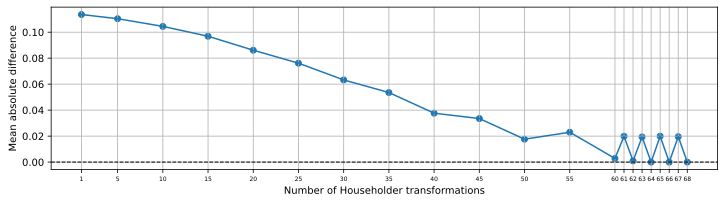

In [395]:
plt.figure(figsize=(12, 3))
plt.plot(Hs, mean_abs_diffs)
plt.scatter(Hs, mean_abs_diffs)
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid()
plt.ylabel("Mean absolute difference")
plt.xlabel("Number of Householder transformations")
plt.xticks(Hs, fontsize=6)
plt.savefig("num_householders_vs_recon_perf_64.png", dpi=300)